In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

from glob import glob

import sys
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


In [2]:


def _weight_variable(shape, name='W'):
    initial = tf.truncated_normal(stddev=0.1, shape=shape)
    return tf.get_variable(name=name, initializer=initial)

def _bias_variable(size, name='b'):
    initial = tf.constant(value=0.1, shape=[size])
    return tf.get_variable(name=name, initializer=initial)

def _linear(input, out_dim):

    in_dim = input.get_shape().as_list()[-1]
    mat_shape = in_dim, out_dim
    W = _weight_variable(mat_shape)

    b = _bias_variable(out_dim)

    return tf.matmul(input, W) + b

def _fully(input, width, scope_name):
    with tf.variable_scope(scope_name):
        lin = _linear(input, width)
    return tf.nn.relu(lin)

def _conv(input, K, D, scope_name):
    
    in_D = input.get_shape().as_list()[-1]
    
    with tf.variable_scope(scope_name):
        kernel = _weight_variable([K, K, in_D, D], 'K')
        bias = _bias_variable(D)
        lin = tf.nn.conv2d(input, kernel, 
                           strides=[1, 1, 1, 1], 
                           padding='SAME')
        
        return tf.nn.relu(lin+bias)
    
def _deconv(input, K, H, W, D, scope_name):
    
    """The transpose of `conv2d`.
    This used to be called "deconvolution", but it is actually the transpose
    (gradient) of `conv2d`, not an actual deconvolution.
    
    Args:
    value: A 4-D `Tensor` of type `float` and shape
      `[batch, height, width, in_channels]`.
      
    filter: A 4-D `Tensor` with the same type as `value` and shape
      `[height, width, output_channels, in_channels]`.  `filter`'s
      `in_channels` dimension must match that of `value`.
      
    output_shape: A 1-D `Tensor` representing the output shape of the
      deconvolution op.
      
    strides: A list of ints. The stride of the sliding window for each
      dimension of the input tensor.
      
    padding: A string, either `'VALID'` or `'SAME'`. The padding algorithm.
    
    name: Optional name for the returned tensor.
    """
    
    # output_shape of conv2d_transpose does not support 
    # implicit/symbolic representation of batch size: 
    # neither '-1' nor 'None' works
    # output_shape = [None, H, W, D]
    
    #Workaround
    batch = tf.shape(input)[0]
    output_shape = [batch, H, W, D]
    
    with tf.variable_scope(scope_name):
        kernel = _weight_variable([K, K, D, in_channels], 'K')
        bias = _bias_variable(D)
        lin = tf.nn.conv2d_transpose(
            value=input, 
            filter=kernel,
            output_shape=output_shape,
            strides=[1, 1, 1, 1], 
            padding='SAME')
    
    
    
    return tf.nn.relu(lin + bias)
    

In [3]:
x = tf.placeholder(tf.float32, [None, 1])
fc1 = _fully(x, 25, 'fc1')
fc2 = _fully(x, 36, 'fc2')
fc3 = _fully(fc1, 49, 'fc3')


In [4]:
shaped = tf.reshape(fc3, [-1, 7, 7, 1])
deconv1 = _deconv(shaped, 3, 7, 7, 32, 'dc1')
deconv2 = _deconv(deconv1, 3, 7, 7, 32, 'dc2')
deconv3 = _deconv(deconv2, 3, 7, 7, 3, 'dc3')

None
None
None


In [5]:
for v in tf.trainable_variables(): print(v.name)

fc1/W:0
fc1/b:0
fc2/W:0
fc2/b:0
fc3/W:0
fc3/b:0
dc1/K:0
dc1/b:0
dc2/K:0
dc2/b:0
dc3/K:0
dc3/b:0


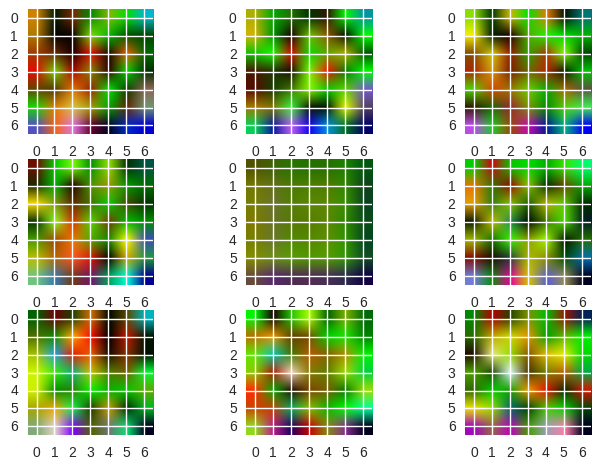

In [22]:
def plot_response(latent_from, latent_to):
    x_feed = np.linspace(latent_from, latent_to, 9)[:, None]
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        response = deconv3.eval(feed_dict={x: x_feed})
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(response[i])

plot_response(-1000, 1000) 

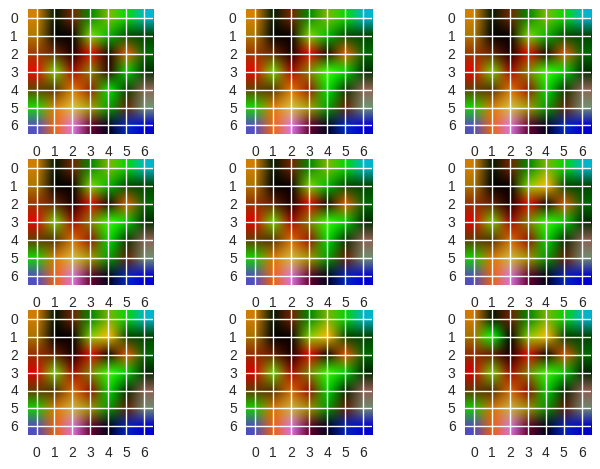

In [27]:
plot_response(-1000, -990)